# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


import pandas as pd
import numpy as np
import itertools

from sklearn.metrics import mean_squared_error
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Step 2: Data Preprocessing

Isolating the State of Georgia

In [4]:
df_GA = df.loc[df['State']=='GA']

Pulling out the Atlanta Metro area

In [5]:
df_Atlanta = df_GA.loc[df_GA['Metro']=='Atlanta']
df_Atlanta.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
28,71067,30349,Riverdale,GA,Atlanta,Clayton,29,90900.0,91100.0,91200.0,...,118700,119900,121400,122900,123800,124600,126200,127300,127700,128100
42,70829,30044,Lawrenceville,GA,Atlanta,Gwinnett,43,111400.0,111800.0,112200.0,...,169500,170900,172800,174700,176400,178500,180100,181000,182200,183400
51,70828,30043,Lawrenceville,GA,Atlanta,Gwinnett,52,135200.0,135500.0,135800.0,...,213600,216000,218400,220300,221900,223700,225500,226700,227800,228800
65,70874,30096,Duluth,GA,Atlanta,Gwinnett,66,119700.0,120000.0,120300.0,...,205900,207600,209400,211200,212700,214600,216500,218100,219800,221100
78,70810,30024,Suwanee,GA,Atlanta,Gwinnett,79,179600.0,181000.0,182400.0,...,330100,331700,333400,334800,336100,338600,341300,343200,344900,346300


In [6]:
df_Atlanta.isna().sum()

RegionID       0
RegionName     0
City           0
State          0
Metro          0
CountyName     0
SizeRank       0
1996-04       22
1996-05       22
1996-06       22
1996-07       22
1996-08       22
1996-09       22
1996-10       22
1996-11       22
1996-12       22
1997-01       22
1997-02       22
1997-03       22
1997-04       22
1997-05       22
1997-06       22
1997-07       22
1997-08       22
1997-09       22
1997-10       22
1997-11       22
1997-12       22
1998-01       22
1998-02       22
              ..
2015-11        0
2015-12        0
2016-01        0
2016-02        0
2016-03        0
2016-04        0
2016-05        0
2016-06        0
2016-07        0
2016-08        0
2016-09        0
2016-10        0
2016-11        0
2016-12        0
2017-01        0
2017-02        0
2017-03        0
2017-04        0
2017-05        0
2017-06        0
2017-07        0
2017-08        0
2017-09        0
2017-10        0
2017-11        0
2017-12        0
2018-01        0
2018-02       

# Step 4: Reshape from Wide to Long Format

In [7]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted


In [8]:
df_atl_melted = melt_data(df_Atlanta)

In [9]:
df_atl_melted.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
0,71067,30349,Riverdale,GA,Atlanta,Clayton,29,1996-04-01,90900.0
1,70829,30044,Lawrenceville,GA,Atlanta,Gwinnett,43,1996-04-01,111400.0
2,70828,30043,Lawrenceville,GA,Atlanta,Gwinnett,52,1996-04-01,135200.0
3,70874,30096,Duluth,GA,Atlanta,Gwinnett,66,1996-04-01,119700.0
4,70810,30024,Suwanee,GA,Atlanta,Gwinnett,79,1996-04-01,179600.0


In [10]:
df_atl_melted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37556 entries, 0 to 40279
Data columns (total 9 columns):
RegionID      37556 non-null int64
RegionName    37556 non-null int64
City          37556 non-null object
State         37556 non-null object
Metro         37556 non-null object
CountyName    37556 non-null object
SizeRank      37556 non-null int64
time          37556 non-null datetime64[ns]
value         37556 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 2.9+ MB


Changing the index to the date for better analysis

In [11]:
df_atl_melted.set_index('time', inplace=True)
df_atl = df_atl_melted

In [12]:
df_atl = df_atl_melted
display(df_atl.head())
display(df_atl.shape)
display(df_atl.isna().sum())

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,71067,30349,Riverdale,GA,Atlanta,Clayton,29,90900.0
1996-04-01,70829,30044,Lawrenceville,GA,Atlanta,Gwinnett,43,111400.0
1996-04-01,70828,30043,Lawrenceville,GA,Atlanta,Gwinnett,52,135200.0
1996-04-01,70874,30096,Duluth,GA,Atlanta,Gwinnett,66,119700.0
1996-04-01,70810,30024,Suwanee,GA,Atlanta,Gwinnett,79,179600.0


(37556, 8)

RegionID      0
RegionName    0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
value         0
dtype: int64

In [13]:
df_atl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37556 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
RegionID      37556 non-null int64
RegionName    37556 non-null int64
City          37556 non-null object
State         37556 non-null object
Metro         37556 non-null object
CountyName    37556 non-null object
SizeRank      37556 non-null int64
value         37556 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 2.6+ MB


# Step 3: EDA and Visualization

In [20]:
df_atl.RegionName.unique().shape

(152,)

Taking a look at the data

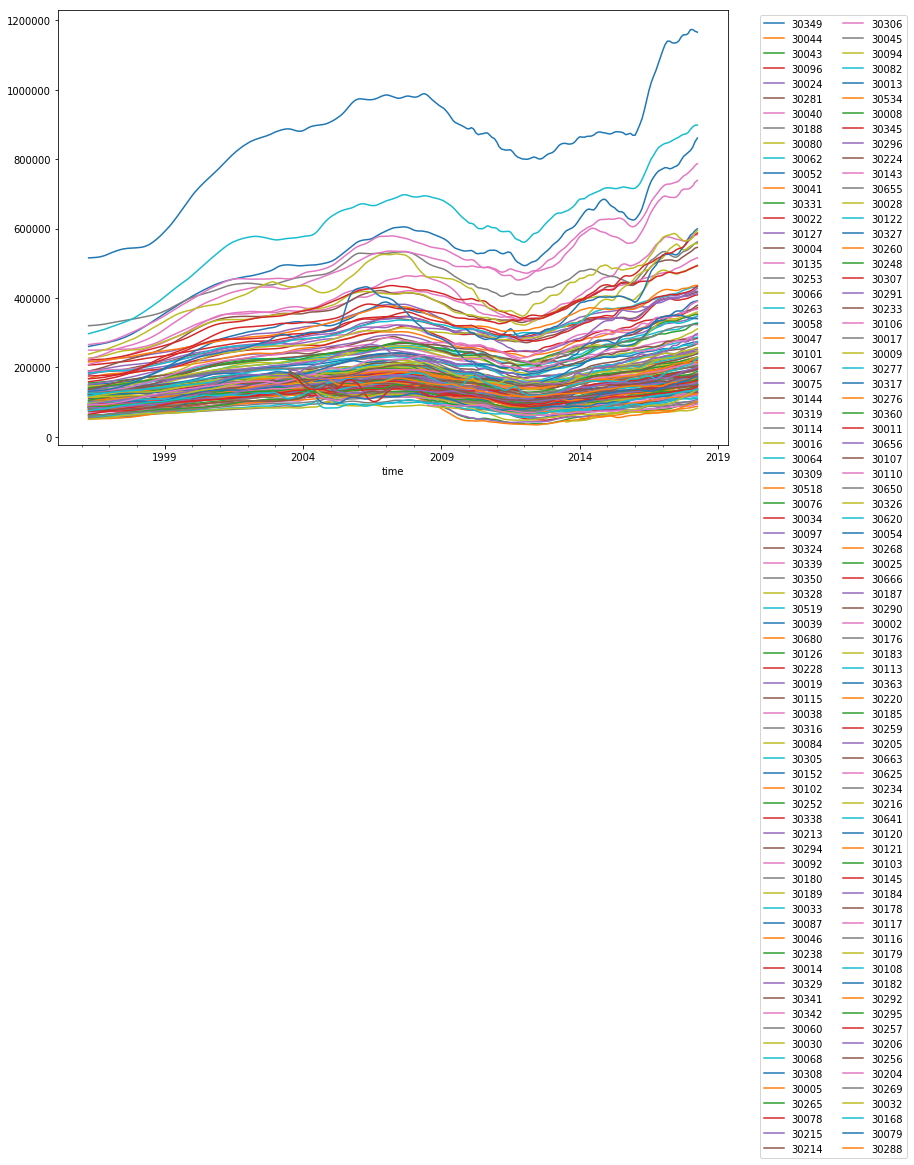

In [14]:

plt.figure(figsize=(12,8))
for zipcode in df_atl.RegionName.unique():
    df_atl.loc[df_atl['RegionName'] == zipcode].value.plot(label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.show()

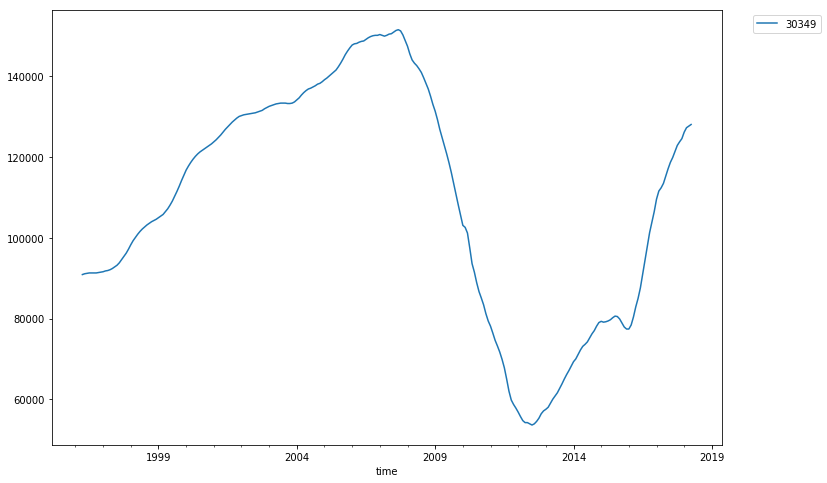

In [17]:

plt.figure(figsize=(12,8))
df_atl.loc[df_atl['RegionName'] == 30349].value.plot(label='30349')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.show()

The housing market bubble is very obvious here.  
We are going to look at the gains by zipcode after the decline began.

In [14]:
df_after_bubble = df_atl.loc[df_atl.index > '2010-01-01']
df_after_bubble.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
2010-02-01,71067,30349,Riverdale,GA,Atlanta,Clayton,29,102600.0
2010-02-01,70829,30044,Lawrenceville,GA,Atlanta,Gwinnett,43,127600.0
2010-02-01,70828,30043,Lawrenceville,GA,Atlanta,Gwinnett,52,158400.0
2010-02-01,70874,30096,Duluth,GA,Atlanta,Gwinnett,66,153500.0
2010-02-01,70810,30024,Suwanee,GA,Atlanta,Gwinnett,79,245900.0


In [21]:
df_atl.value.mean()

190124.2624347641

In [22]:
df_atl.value.max()

1173200.0

In [23]:
df_atl.value.min()

34400.0

Here we are calculating the greatest gain in mean price and returning the top 10 results.

In [15]:

diff = pd.DataFrame()
diffdict = {}
for zipcode in df_after_bubble.RegionName.unique():
    low = df_after_bubble.loc[df_after_bubble['RegionName'] == zipcode].value.min()
    high = df_after_bubble.loc[df_after_bubble['RegionName'] == zipcode].value.max()
    diffdict[zipcode] = high - low
diff['zipcode'] = diffdict.keys()
diff['change'] = diffdict.values()
most_change = list(diff.sort_values(by='change', ascending=False).zipcode[:10])

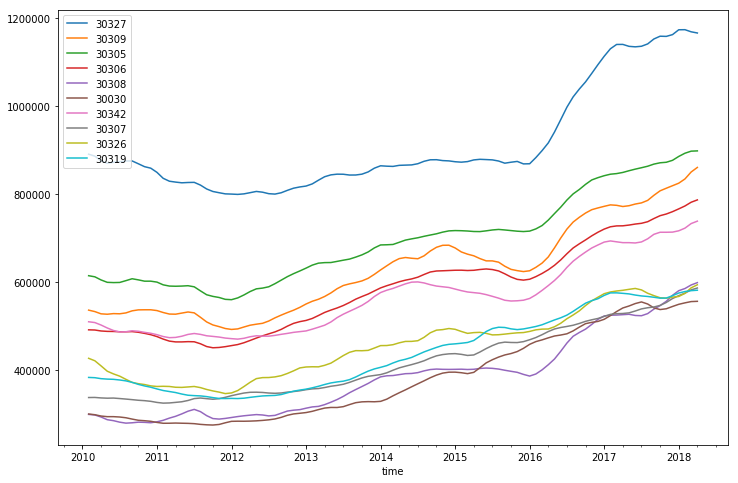

In [16]:
plt.figure(figsize=(12,8))
for zipcode in most_change:
    zipdf = df_after_bubble[df_after_bubble['RegionName'] == zipcode].value
    zipdf.plot(label=zipcode)
plt.legend()
plt.show()

In [17]:
df_best = df_Atlanta.loc[df_Atlanta['RegionName'].isin(most_change)]
df_best

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
640,71039,30319,Brookhaven,GA,Atlanta,Dekalb,641,208800.0,210400.0,211900.0,...,569100,567900,566100,564100,564300,569600,575700,579100,581100,582100
1097,71029,30309,Atlanta,GA,Atlanta,Fulton,1098,260400.0,261700.0,262900.0,...,780200,785900,797400,807600,813500,819200,824900,834500,850300,860700
1787,71025,30305,Atlanta,GA,Atlanta,Fulton,1788,297200.0,299000.0,300900.0,...,860000,863400,868200,871200,872400,876800,885600,892900,897600,898200
2519,71060,30342,Sandy Springs,GA,Atlanta,Fulton,2520,265800.0,266700.0,267600.0,...,691600,698700,708900,713600,713600,713900,716900,722900,733300,738800
2705,70815,30030,Decatur,GA,Atlanta,Dekalb,2706,131000.0,131500.0,132100.0,...,555500,550800,542000,538200,540000,545200,550100,553400,556300,556900
2757,71028,30308,Atlanta,GA,Atlanta,Fulton,2758,138700.0,139400.0,140100.0,...,524200,529000,539200,547200,557000,570500,581000,585900,594000,599300
3261,71026,30306,Atlanta,GA,Atlanta,Fulton,3262,223100.0,225200.0,227400.0,...,733900,737500,744700,751200,755000,760300,766600,773200,781700,787000
4455,71046,30327,Atlanta,GA,Atlanta,Fulton,4456,515500.0,515900.0,516300.0,...,1135600,1140900,1152100,1158400,1158000,1162000,1173000,1173200,1168400,1165700
4643,71027,30307,Atlanta,GA,Atlanta,Fulton,4644,158900.0,159700.0,160500.0,...,539700,542300,544000,547600,554300,563200,569700,575400,582900,587100
7641,71045,30326,Atlanta,GA,Atlanta,Fulton,7642,238100.0,240100.0,242100.0,...,582800,575200,569800,565000,564000,566500,567900,574900,587500,594400


In [18]:
df_best_melted = melt_data(df_best)
df_best_melted.keys()

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', 'time', 'value'],
      dtype='object')

In [19]:
df_best_melted.set_index("time", inplace=True)
df1 = df_best_melted
df1.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,71039,30319,Brookhaven,GA,Atlanta,Dekalb,641,208800.0
1996-04-01,71029,30309,Atlanta,GA,Atlanta,Fulton,1098,260400.0
1996-04-01,71025,30305,Atlanta,GA,Atlanta,Fulton,1788,297200.0
1996-04-01,71060,30342,Sandy Springs,GA,Atlanta,Fulton,2520,265800.0
1996-04-01,70815,30030,Decatur,GA,Atlanta,Dekalb,2706,131000.0


In [20]:
df1.head(10)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,71039,30319,Brookhaven,GA,Atlanta,Dekalb,641,208800.0
1996-04-01,71029,30309,Atlanta,GA,Atlanta,Fulton,1098,260400.0
1996-04-01,71025,30305,Atlanta,GA,Atlanta,Fulton,1788,297200.0
1996-04-01,71060,30342,Sandy Springs,GA,Atlanta,Fulton,2520,265800.0
1996-04-01,70815,30030,Decatur,GA,Atlanta,Dekalb,2706,131000.0
1996-04-01,71028,30308,Atlanta,GA,Atlanta,Fulton,2758,138700.0
1996-04-01,71026,30306,Atlanta,GA,Atlanta,Fulton,3262,223100.0
1996-04-01,71046,30327,Atlanta,GA,Atlanta,Fulton,4456,515500.0
1996-04-01,71027,30307,Atlanta,GA,Atlanta,Fulton,4644,158900.0


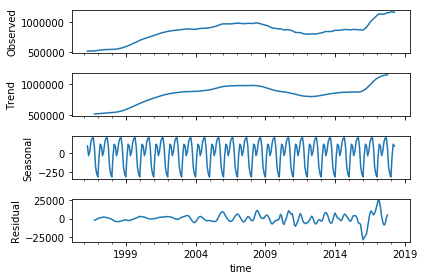

In [21]:
decomp = seasonal_decompose(df1[df1['RegionName'] == 30327].value)
decomp.plot();

# Step 5: ARIMA Modeling

In [22]:
test = df1.loc[df1['RegionName'] == 30327]

In [23]:
model_arima = sm.tsa.statespace.SARIMAX(test.value,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12), 
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model_arima.fit()
display(results.summary().tables[0], results.summary().tables[1], results.summary().tables[2])

Dep. Variable:,value,No. Observations:,265
Model:,"SARIMAX(1, 1, 1)x(1, 1, 0, 12)",Log Likelihood,-2292.349
Date:,"Mon, 02 Dec 2019",AIC,4592.698
Time:,01:24:40,BIC,4606.604
Sample:,04-01-1996,HQIC,4598.302
,- 04-01-2018,,
Covariance Type:,opg,,


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.8465,0.027,30.957,0.000,0.793,0.900
ma.L1,0.0611,0.014,4.465,0.000,0.034,0.088
ar.S.L12,-0.4395,0.037,-12.023,0.000,-0.511,-0.368
sigma2,1.154e+07,9.11e-10,1.27e+16,0.000,1.15e+07,1.15e+07


Ljung-Box (Q):,187.88,Jarque-Bera (JB):,156.97
Prob(Q):,0.00,Prob(JB):,0.00
Heteroskedasticity (H):,23.75,Skew:,-0.06
Prob(H) (two-sided):,0.00,Kurtosis:,6.97


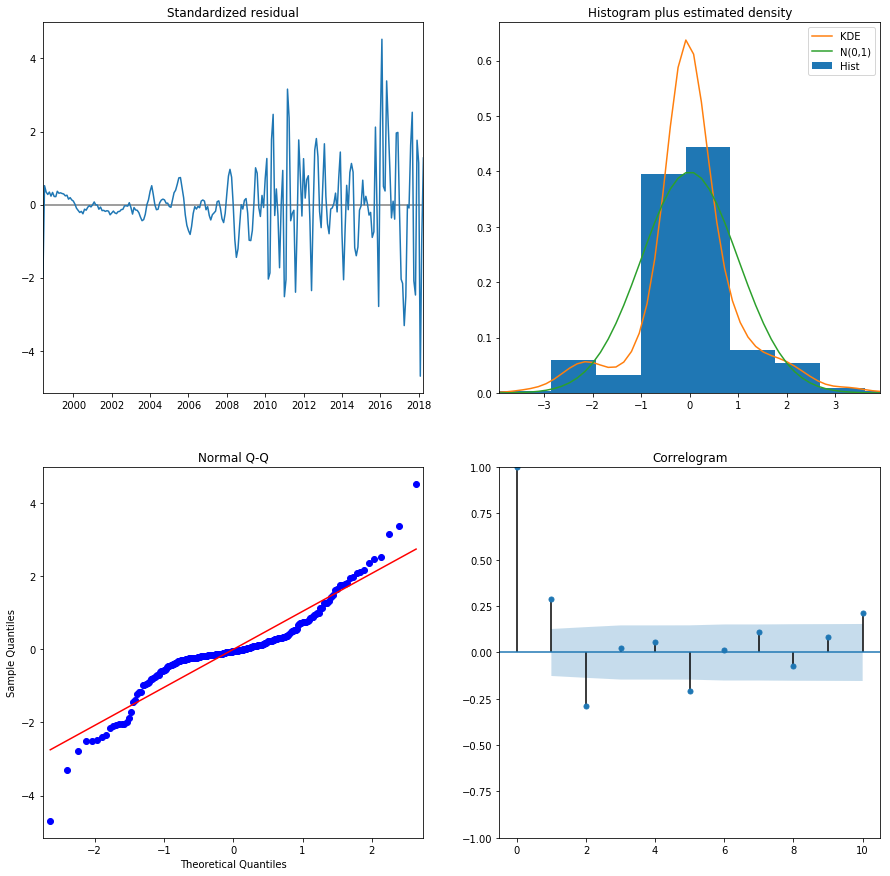

In [24]:
results.plot_diagnostics(figsize=(15,15))
plt.show()

In [25]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [26]:
pred_conf.head()

,lower value,upper value
2016-01-01,855200.725669,868517.522985
2016-02-01,860968.148657,874284.945973
2016-03-01,890450.371516,903767.168833
2016-04-01,908374.191315,921690.988632
2016-05-01,922841.996567,936158.793883


In [27]:
b = {}
b['a'] = pred_conf[pred_conf.index == '2016-02-01']['lower value'][0]

In [28]:
b


{'a': 860968.1486566477}

In [29]:
pred_conf[pred_conf.index == '2016-02-01']['lower value']

2016-02-01    860968.148657
Freq: MS, Name: lower value, dtype: float64

In [30]:
pred_conf


,lower value,upper value
2016-01-01,8.552007e+05,8.685175e+05
2016-02-01,8.609681e+05,8.742849e+05
2016-03-01,8.904504e+05,9.037672e+05
2016-04-01,9.083742e+05,9.216910e+05
2016-05-01,9.228420e+05,9.361588e+05
2016-06-01,9.549867e+05,9.683035e+05
2016-07-01,9.873870e+05,1.000704e+06
2016-08-01,1.015276e+06,1.028593e+06
2016-09-01,1.031626e+06,1.044943e+06
2016-10-01,1.049495e+06,1.062812e+06


In [31]:
b

{'a': 860968.1486566477}

In [32]:
pred_conf['upper value'].mean()

1082319.8008644131

In [33]:
pred.predicted_mean['2018-01-01']

1169118.1994830507

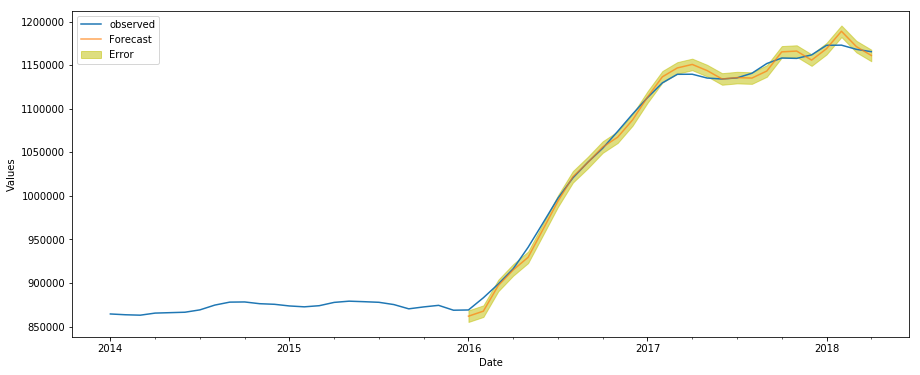

In [34]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = test['2014':].value.plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                label='Error' ,color='y', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend()

plt.show()

In [35]:
test_forecasted = pred.predicted_mean
test_truth = test['2016':].value
test_forecasted = test_forecasted['2016':]
# Compute the root mean square error
error = mean_squared_error(test_forecasted, test_truth)
error = np.sqrt(error)
print(f'The RMSE of our forecasts is {error}')

The RMSE of our forecasts is 7178.582808106482


In [36]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [37]:
best_combs = []
for zipcode in tqdm(df1.RegionName.unique()):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df1.loc[df1['RegionName'] == zipcode].value,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                result = mod.fit()
                ans.append([zipcode, comb, combs, result.aic])
    #             print(f'ARIMA {comb} x {combs}12 : AIC Calculated ={output.aic}')
            except:
                continue
    best_combs.append(sorted(ans, key=lambda x: x[3])[0])

100%|██████████| 10/10 [03:34<00:00, 21.41s/it]


In [38]:
best_combs


[[30319, (1, 1, 1), (1, 1, 1, 12), 4017.114498913459],
 [30309, (1, 1, 1), (1, 0, 1, 12), 4374.796047944819],
 [30305, (1, 1, 1), (0, 0, 1, 12), 4322.921012340776],
 [30342, (1, 1, 1), (0, 1, 1, 12), 4214.890538875619],
 [30030, (1, 1, 1), (1, 1, 1, 12), 4114.326208379544],
 [30308, (1, 1, 1), (1, 1, 1, 12), 4317.966550993795],
 [30306, (1, 1, 1), (1, 1, 1, 12), 4056.7545584909103],
 [30327, (1, 1, 1), (0, 1, 1, 12), 4527.565869442316],
 [30307, (1, 1, 1), (0, 1, 1, 12), 4018.1732133097767],
 [30326, (1, 1, 1), (1, 1, 1, 12), 4359.935072767291]]

In [62]:
test = df1

In [63]:
model_arima = sm.tsa.statespace.SARIMAX(test.value,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12), 
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model_arima.fit()
display(results.summary().tables[0], results.summary().tables[1], results.summary().tables[2])

Dep. Variable:,value,No. Observations:,2650
Model:,"SARIMAX(1, 1, 1)x(1, 1, 1, 12)",Log Likelihood,-35889.021
Date:,"Mon, 02 Dec 2019",AIC,71788.043
Time:,02:12:13,BIC,71817.403
Sample:,0,HQIC,71798.676
,- 2650,,
Covariance Type:,opg,,


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.1807,0.232,-0.777,0.437,-0.636,0.275
ma.L1,-0.8987,0.066,-13.689,0.000,-1.027,-0.770
ar.S.L12,-0.6314,0.102,-6.209,0.000,-0.831,-0.432
ma.S.L12,-0.9298,0.065,-14.279,0.000,-1.057,-0.802
sigma2,1.028e+11,2.72e-13,3.79e+23,0.000,1.03e+11,1.03e+11


Ljung-Box (Q):,17875.60,Jarque-Bera (JB):,45.47
Prob(Q):,0.00,Prob(JB):,0.00
Heteroskedasticity (H):,0.95,Skew:,0.29
Prob(H) (two-sided):,0.48,Kurtosis:,2.74


In [73]:
def make_pred_image(df, test_forecasted, forcast, zipcode=None):
    rcParams['figure.figsize'] = 15, 6

    #Plot observed values
    ax = df['2015':].plot(label='observed')

    #Plot predicted values
    test_forecasted['2015-01-01':].plot(ax=ax, label='Predicted', alpha=.7)
    
    forcast.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='y', alpha=.5)

    #Set axes labels
#     ax.title(zipcode)
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    plt.legend()

    plt.show()
    return None

30319


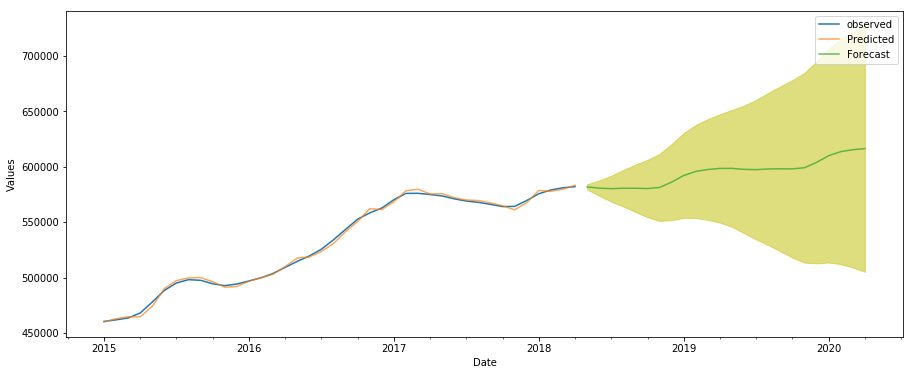

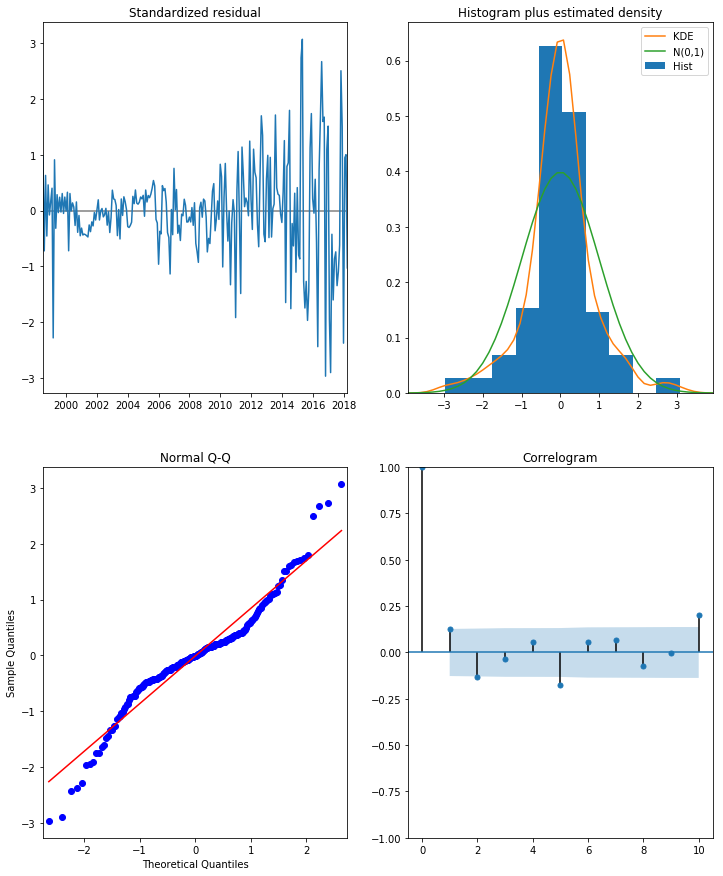

30309


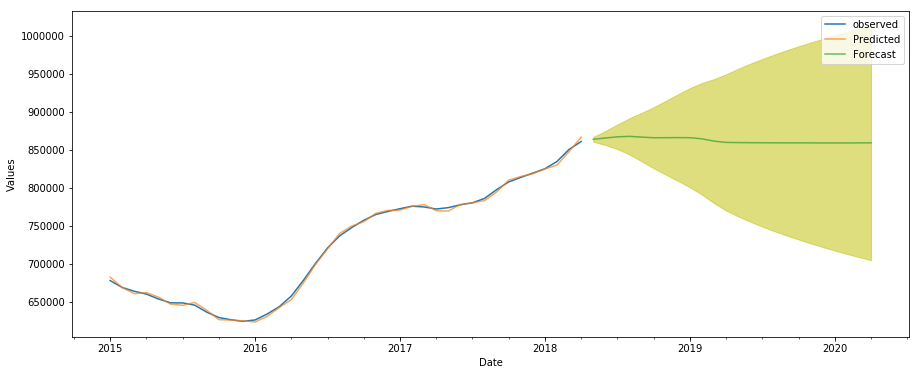

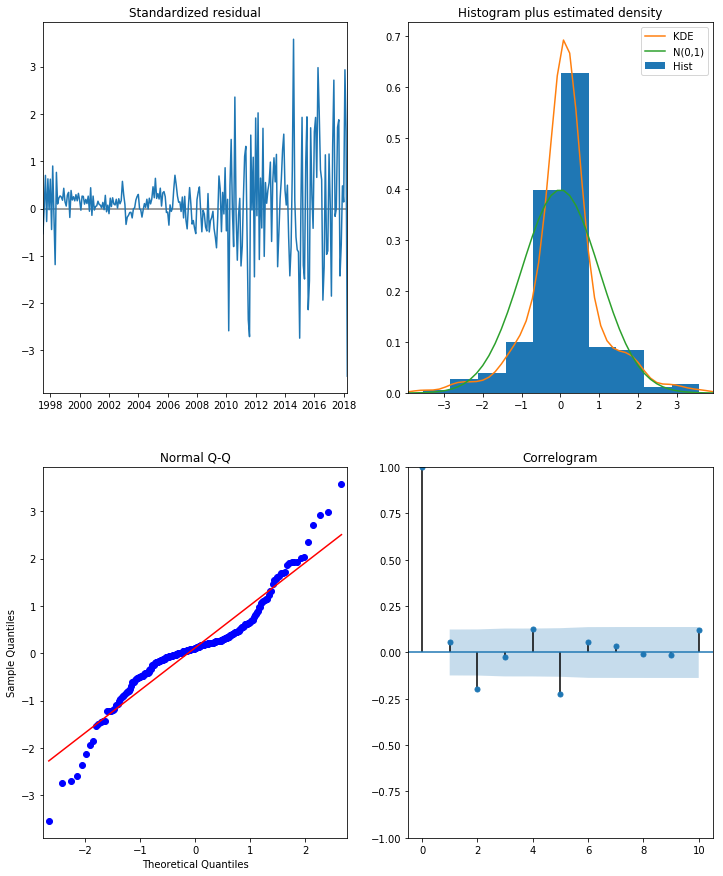

30305


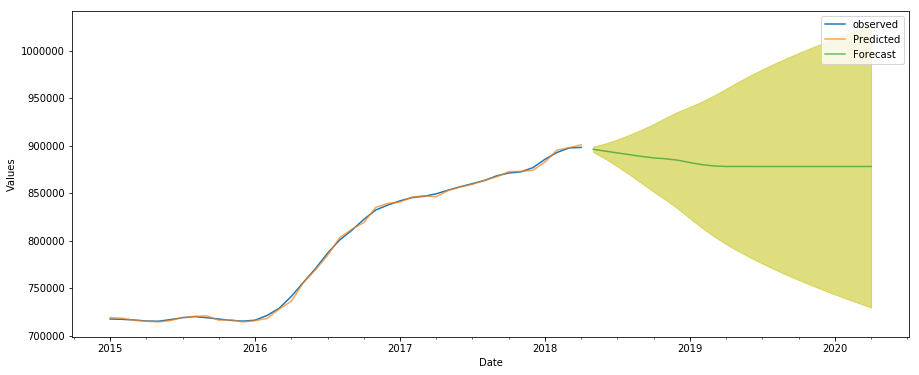

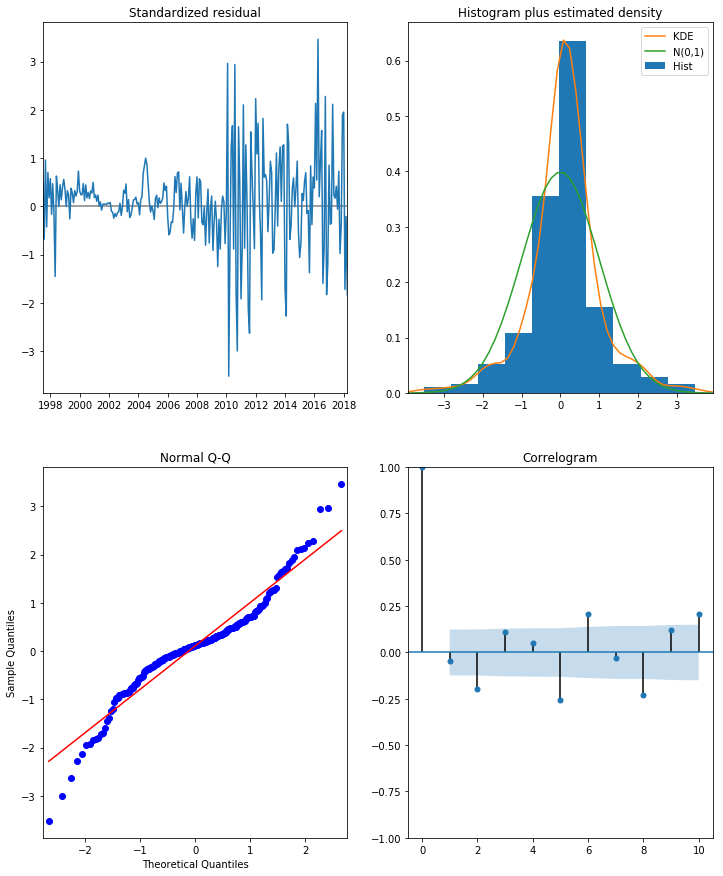

30342


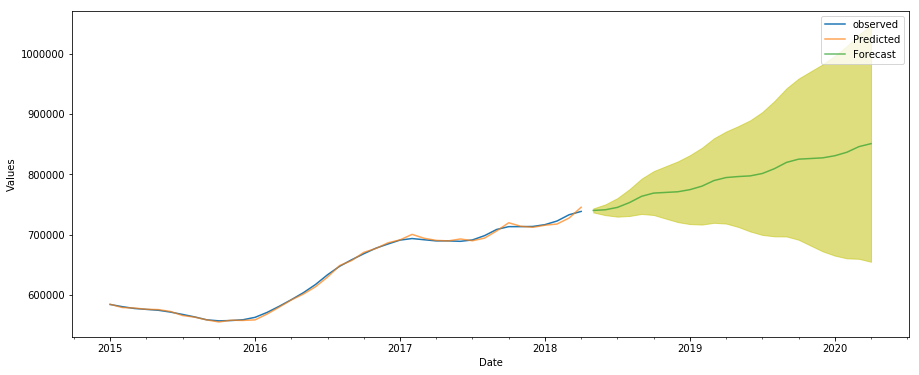

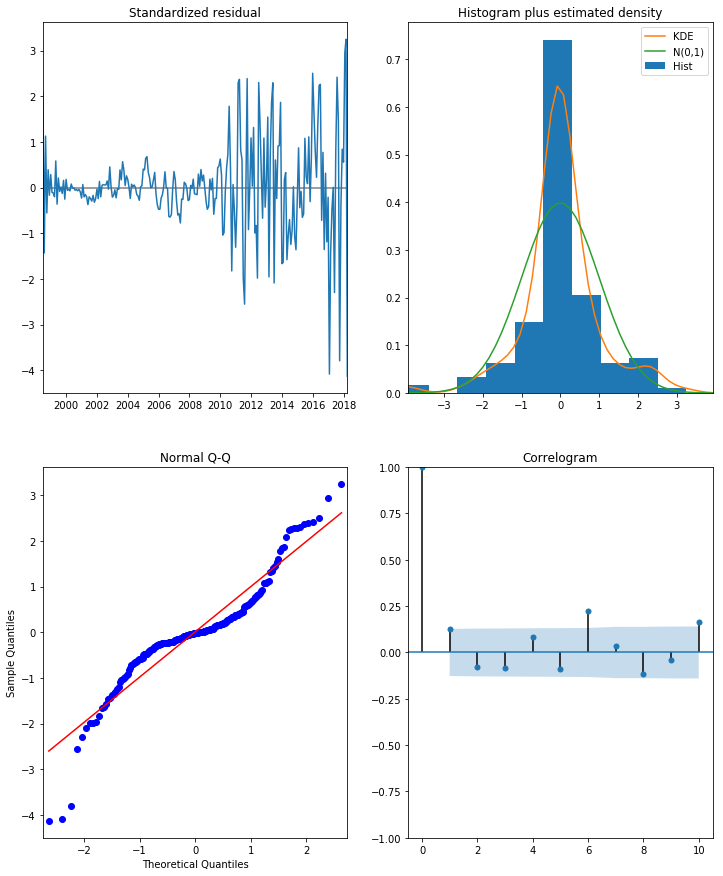

30030


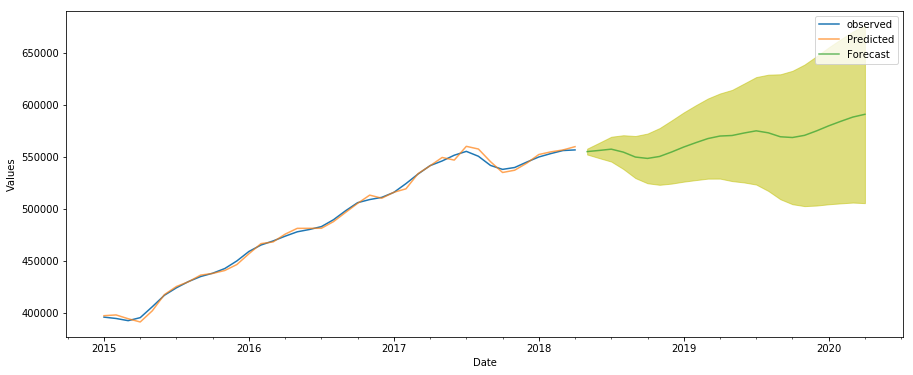

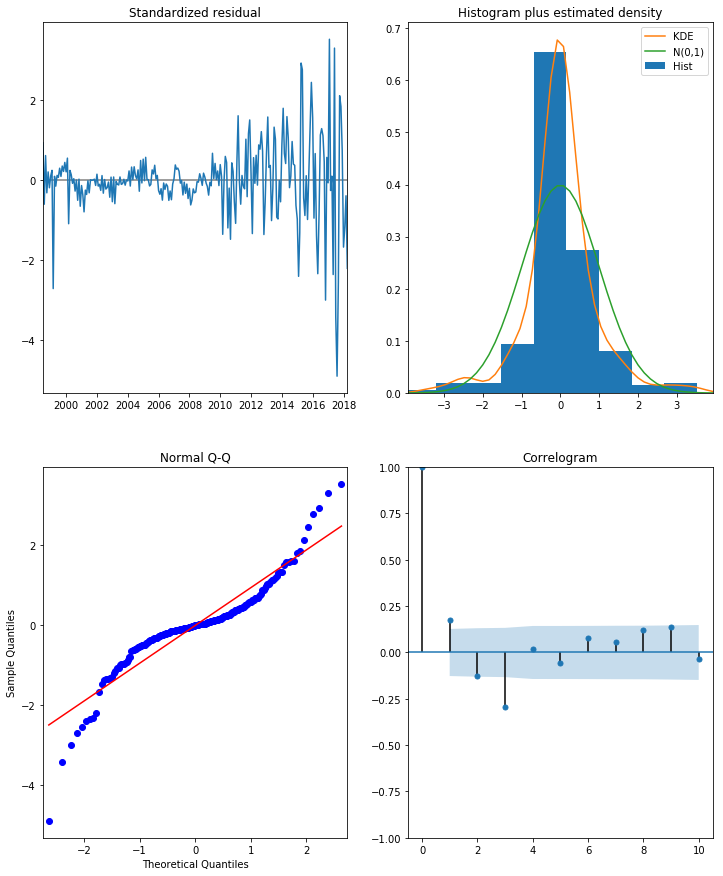

30308


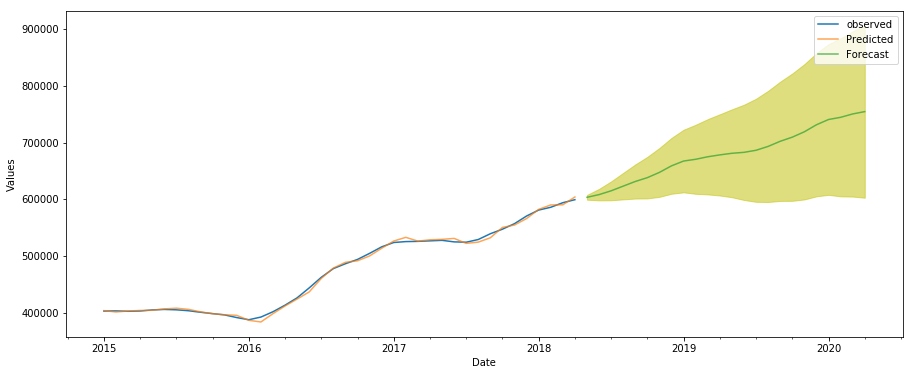

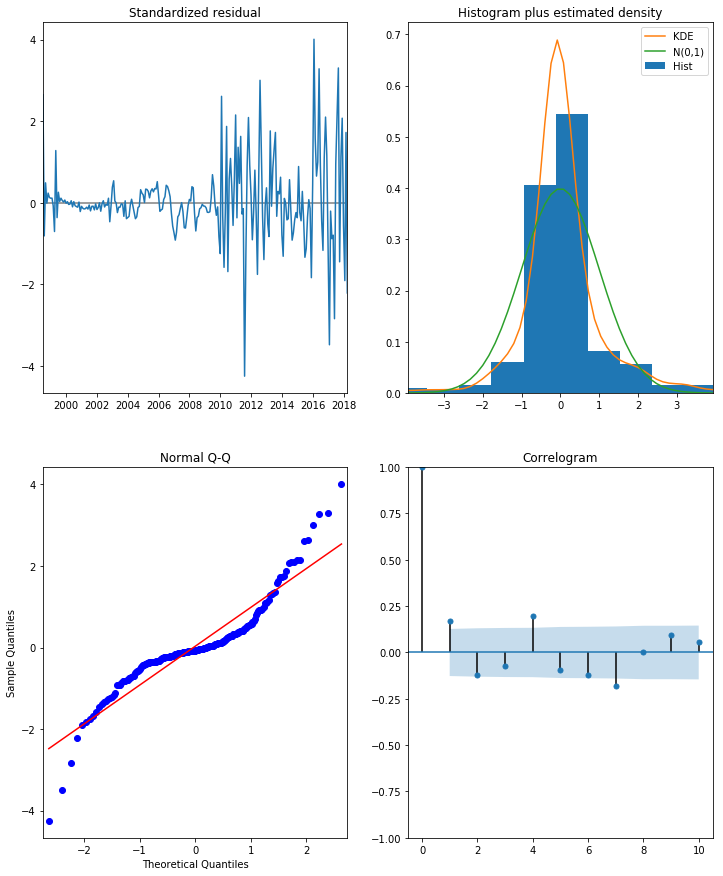

30306


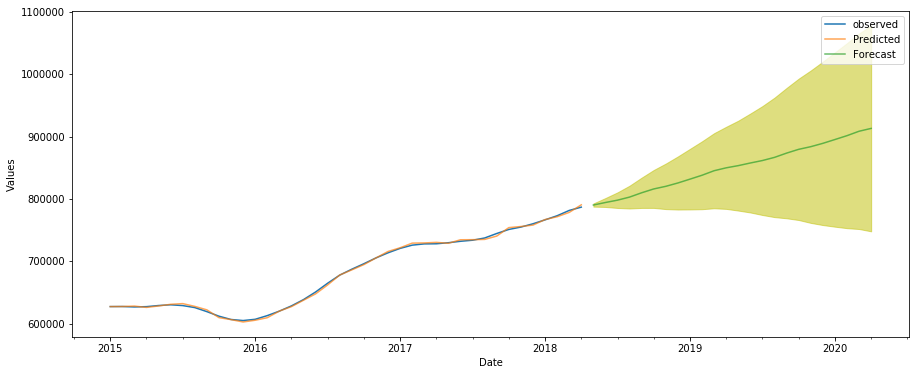

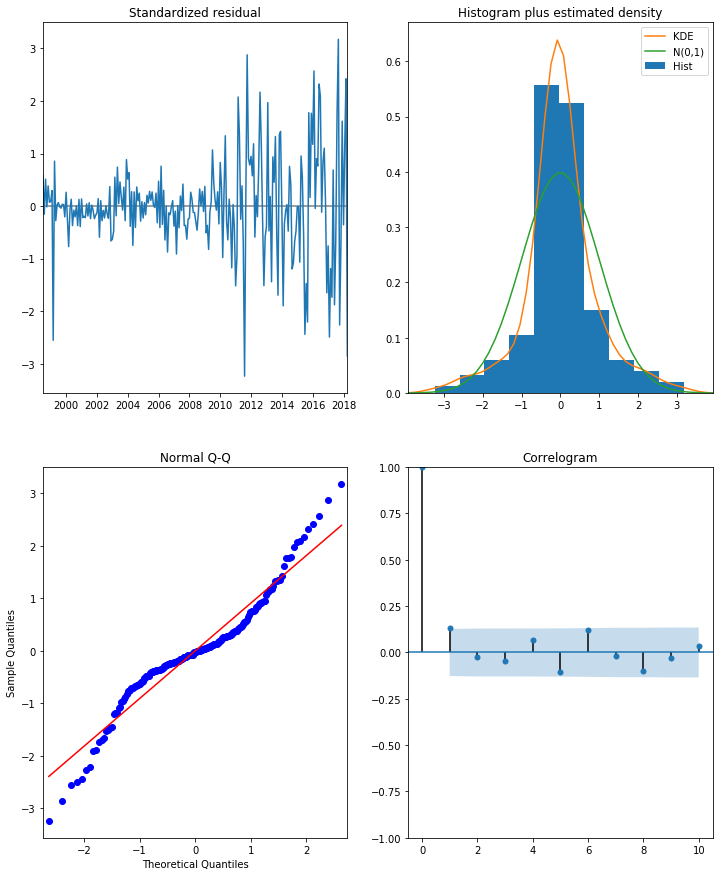

30327


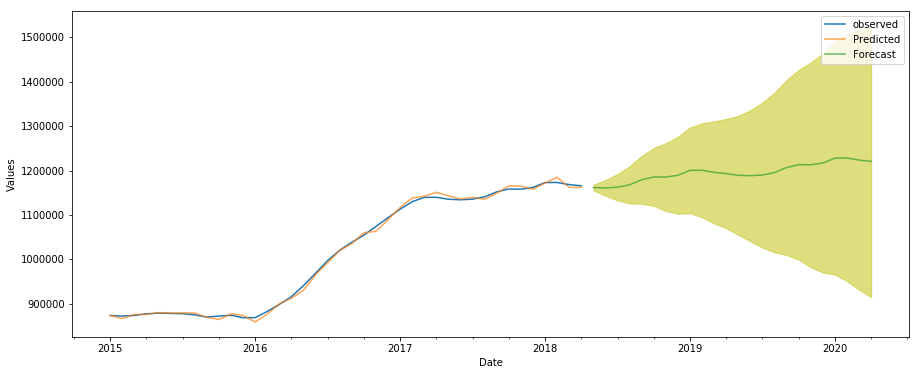

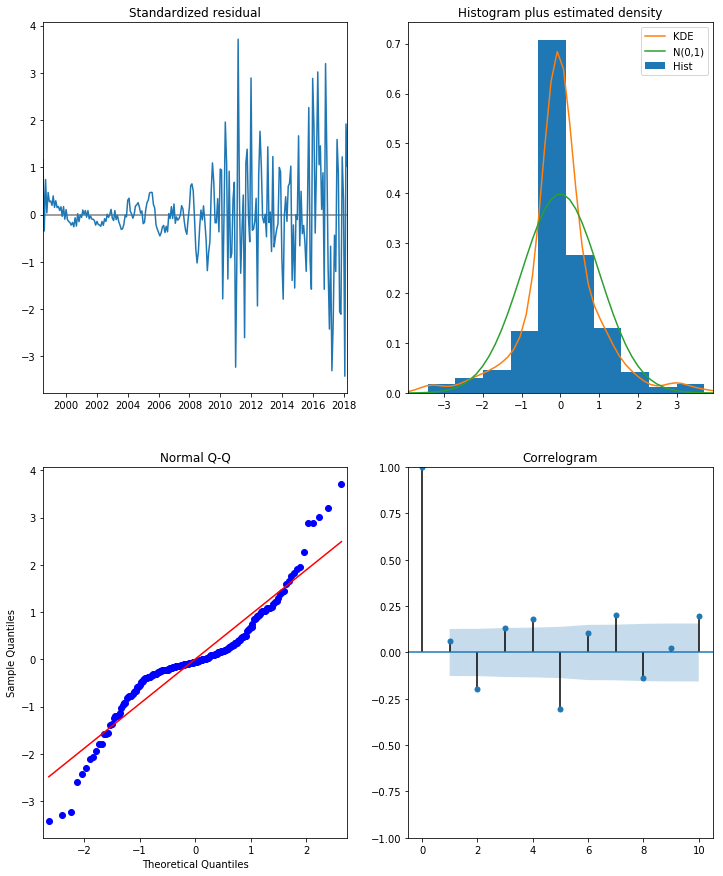

30307


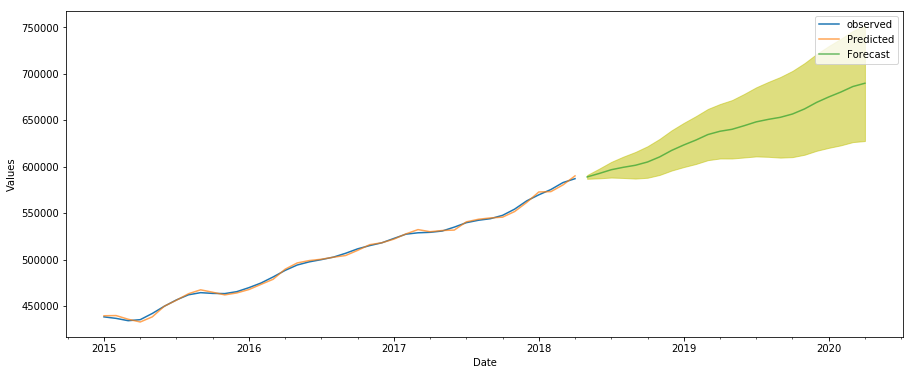

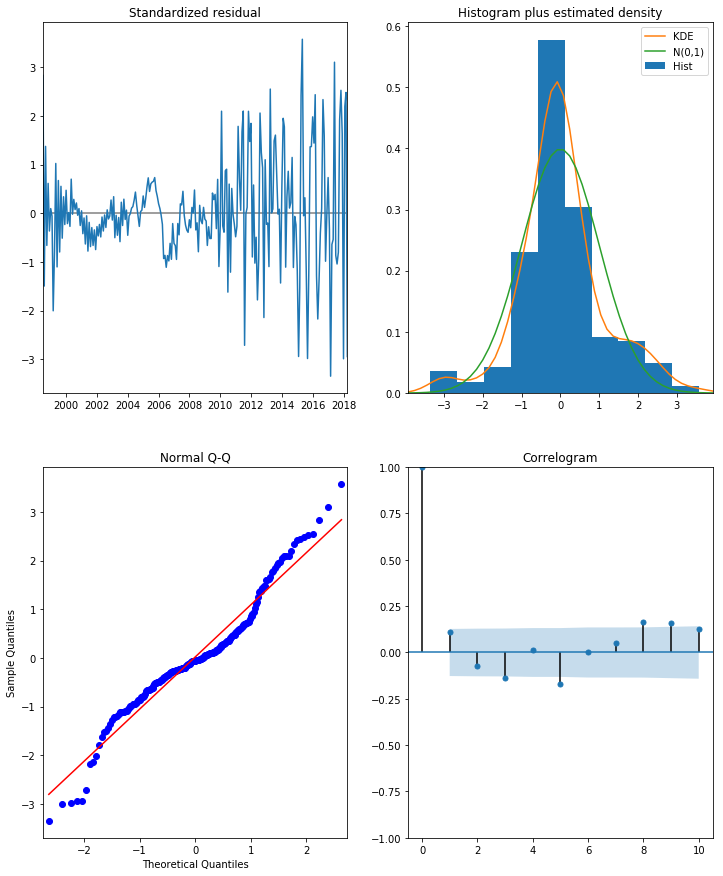

30326


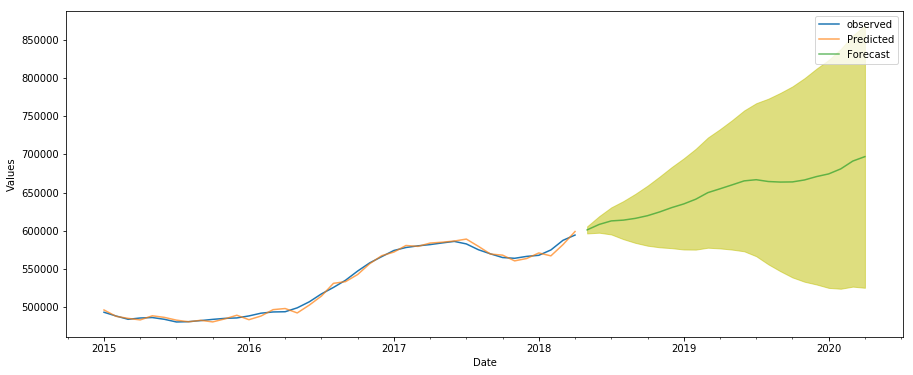

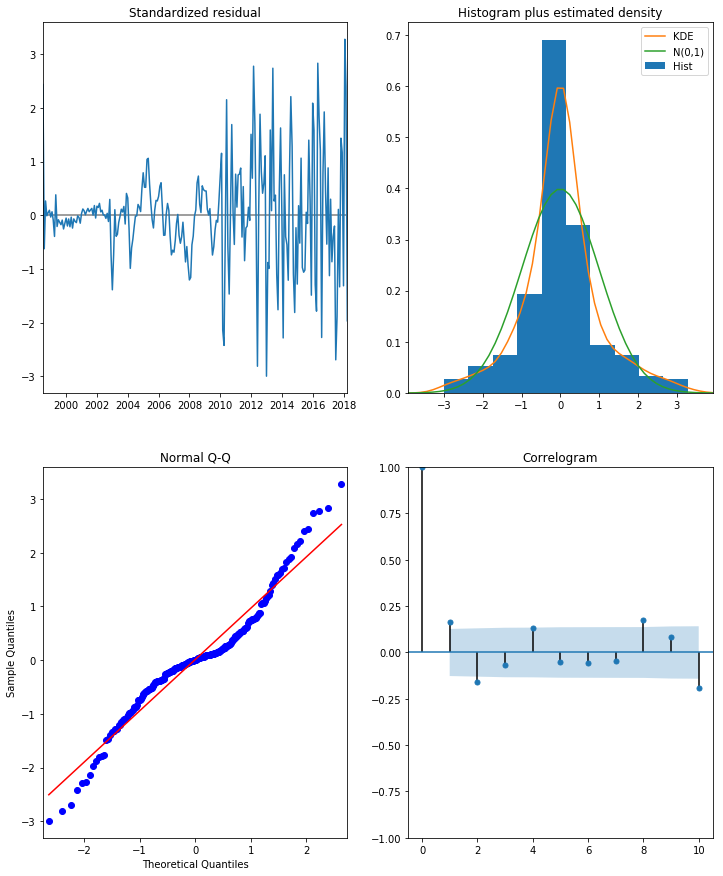

In [104]:
pred_df = pd.DataFrame()
known_RMSE = {}
forecast_2019_04 = {}
confid_min = {}
confid_max = {}
profit = {}
roi = {}
last_recorded_price = {}

for comb in best_combs:
    df = df1.loc[df1['RegionName'] == comb[0]].value.dropna()
    mod = sm.tsa.statespace.SARIMAX(df,
                                    order=comb[1],
                                    seasonal_order=comb[2],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    pred = results.get_prediction(start=pd.to_datetime('1996-04-01'), dynamic=False)
    test_forecasted = pred.predicted_mean
    test_truth = test['1996-04-01':].value
    test_forecasted = test_forecasted['1996-04-01':]
    forecast = results.get_forecast(steps=24)
    forecast_2019_04[comb[0]] = forecast.predicted_mean['2019-04-01']
    pred_conf = forecast.conf_int()
    confid_min[comb[0]] = pred_conf[pred_conf.index == '2019-04-01']['lower value'][0]
    confid_max[comb[0]] = pred_conf[pred_conf.index == '2019-04-01']['upper value'][0]
    last_record = df1.loc[df1['RegionName'] == comb[0]].value[-1]
    profit[comb[0]] = forecast.predicted_mean['2019-04'] - last_record
    roi[comb[0]] = profit[comb[0]]/last_record
    last_recorded_price[comb[0]] = last_record
    
    print(comb[0])
    make_pred_image(df, test_forecasted, forecast)
    results.plot_diagnostics(figsize=(12, 15))
    plt.show()

pred_df['zipcode'] = confid_min.keys()
pred_df['price_2018_04'] = last_recorded_price.values()
pred_df['forecast_2019_04'] = forecast_2019_04.values()
pred_df['confid_min'] = confid_min.values()
pred_df['confid_max'] = confid_max.values()
pred_df['profit'] = profit.values()
pred_df['roi'] = roi.values()  

In [105]:
pred_df

,zipcode,price_2018_04,forecast_2019_04,confid_min,confid_max,profit,roi
0,30319,582100.0,5.985673e+05,5.496325e+05,6.475021e+05,"(16467.284713586327,)","(0.028289442902570565,)"
1,30309,860700.0,8.594984e+05,7.700011e+05,9.489958e+05,"(-1201.5783848197898,)","(-0.0013960478503773554,)"
2,30305,898200.0,8.781083e+05,7.962393e+05,9.599773e+05,"(-20091.681695479667,)","(-0.022368828429614414,)"
3,30342,738800.0,7.949026e+05,7.186681e+05,8.711370e+05,"(56102.58474830864,)","(0.07593744551747245,)"
4,30030,556900.0,5.702344e+05,5.293315e+05,6.111373e+05,"(13334.375626381137,)","(0.023943931812499798,)"
5,30308,599300.0,6.784365e+05,6.066820e+05,7.501911e+05,"(79136.5125749918,)","(0.13204824390954747,)"
6,30306,787000.0,8.501128e+05,7.841934e+05,9.160322e+05,"(63112.7983489614,)","(0.08019415292117077,)"
7,30327,1165700.0,1.193197e+06,1.069901e+06,1.316492e+06,"(27496.54562468105,)","(0.02358801203112383,)"
8,30307,587100.0,6.381836e+05,6.088533e+05,6.675138e+05,"(51083.567796330084,)","(0.08700999454322958,)"
9,30326,594400.0,6.548913e+05,5.769395e+05,7.328431e+05,"(60491.29524038418,)","(0.10176866628597607,)"


In [106]:
pred_df['forecast_2019_04'] = pred_df['forecast_2019_04'].apply(lambda x: round(x, 2))
pred_df['confid_min'] = pred_df['confid_min'].apply(lambda x: round(x, 2))
pred_df['confid_max'] = pred_df['confid_max'].apply(lambda x: round(x, 2))
pred_df['profit'] = pred_df['profit'].apply(lambda x: round(x[0], 2))
pred_df['roi'] = pred_df['roi'].apply(lambda x: round(x[0], 2))

In [109]:
pred_df.sort_values('roi', ascending=False)

,zipcode,price_2018_04,forecast_2019_04,confid_min,confid_max,profit,roi
5,30308,599300.0,678436.51,606681.96,750191.06,79136.51,0.13
9,30326,594400.0,654891.30,576939.46,732843.13,60491.30,0.10
8,30307,587100.0,638183.57,608853.30,667513.83,51083.57,0.09
3,30342,738800.0,794902.58,718668.12,871137.05,56102.58,0.08
6,30306,787000.0,850112.80,784193.39,916032.21,63112.80,0.08
0,30319,582100.0,598567.28,549632.49,647502.08,16467.28,0.03
4,30030,556900.0,570234.38,529331.48,611137.27,13334.38,0.02
7,30327,1165700.0,1193196.55,1069900.63,1316492.46,27496.55,0.02
1,30309,860700.0,859498.42,770001.06,948995.78,-1201.58,-0.00
2,30305,898200.0,878108.32,796239.31,959977.33,-20091.68,-0.02
